In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742238083.9322762.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742219610.8224277.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742236517.8713465.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742238068.3843164.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742238075.2987812.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742236499.300406.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1742236520.2454073.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1741876367.2255726.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1741876368.7836459.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chatura/Mudra_1741876359.6800082.jpg
/kaggle/input/bharatnatyam-mudras350/Datasets/Validation/Chat

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

2025-05-07 03:16:56.108587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746587816.298099      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746587816.352686      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define path to your dataset
train_dataset = "/kaggle/input/bharatnatyam-mudras350/Datasets/reduced_train_data"
val_dataset = "/kaggle/input/bharatnatyam-mudras350/Datasets/Validation"
test_dataset = "/kaggle/input/bharatnatyam-mudras350/Datasets/Testing" 

In [4]:
# Load dataset (only for visualization here, not for training yet)
dataset = image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    label_mode='int',         # or 'categorical' for one-hot
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

# Get class names
class_names = dataset.class_names
num_classes=len(class_names)
print("Classes:", class_names)

Found 9800 files belonging to 28 classes.


I0000 00:00:1746587829.933563      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Classes: ['Alapadma', 'Arala', 'Ardhachandra', 'Ardhapathaka', 'Bhramara', 'Chandrakala', 'Chatura', 'Hamsapaksha', 'Hamsasya', 'Kangula', 'Kapittha', 'Kartarimukha', 'Katakamukha', 'Mayura', 'Mrigashirsha', 'Mukula', 'Mushti', 'Padmakosha', 'Pathaka', 'Samdamsha', 'Sarpashirsha', 'Shikhara', 'Shukatunda', 'Simhamukha', 'Suchi', 'Tamrachuda', 'Tripathaka', 'Trishula']


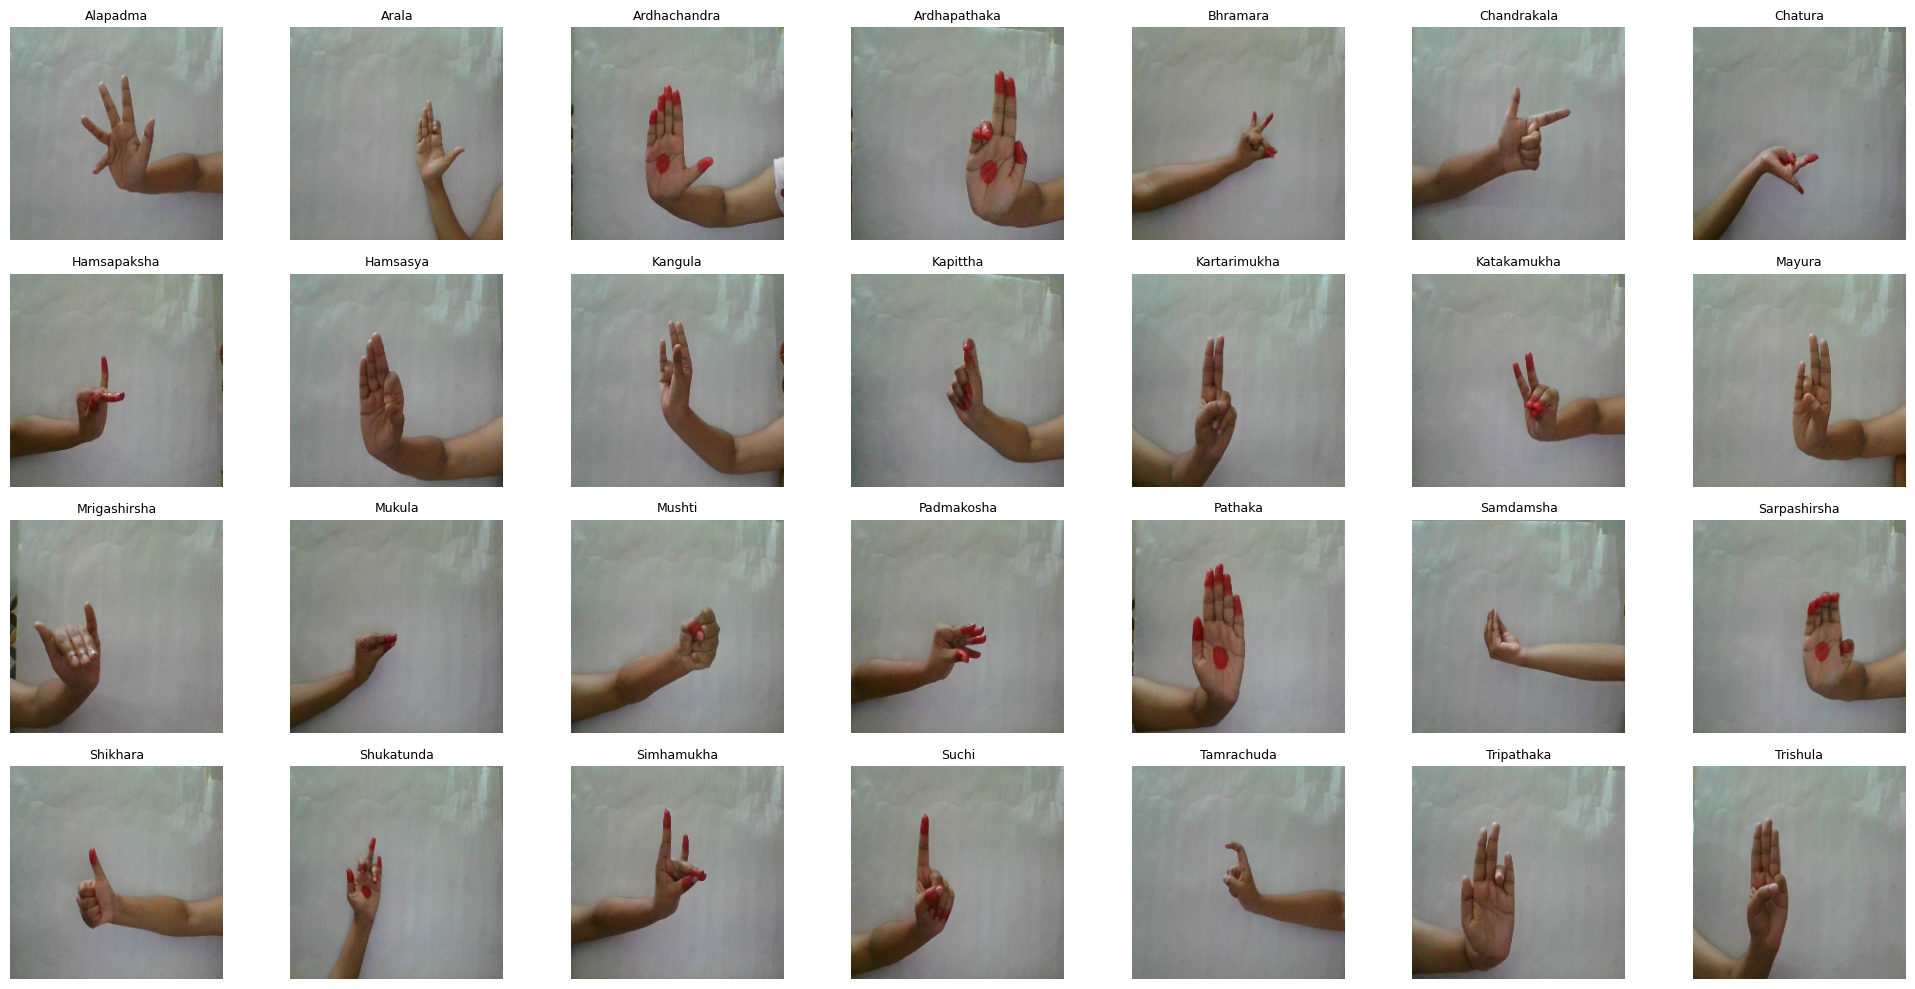

In [5]:
# Visualize a batch of images

sample_per_class = {}

# Iterate over the dataset to collect one image per class
for images, labels in dataset:
    for img, label in zip(images, labels):
        class_label = label.numpy()
        if class_label not in sample_per_class:
            sample_per_class[class_label] = img.numpy()
        if len(sample_per_class) == len(class_names):
            break
    if len(sample_per_class) == len(class_names):
        break

# Plotting all 28 classes
plt.figure(figsize=(20, 10))
for idx, class_id in enumerate(sorted(sample_per_class.keys())):
    plt.subplot(4, 7, idx + 1)
    plt.imshow(sample_per_class[class_id].astype("uint8"))
    plt.title(class_names[class_id], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Common settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load datasets
train_ds = image_dataset_from_directory(
    train_dataset,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # or 'categorical' if you prefer one-hot
)

val_ds = image_dataset_from_directory(
    val_dataset,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = image_dataset_from_directory(
    test_dataset,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 9800 files belonging to 28 classes.
Found 2800 files belonging to 28 classes.
Found 2800 files belonging to 28 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load pre-trained model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze weights

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Build model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),  # Normalize images

    base_model,  # Pretrained feature extractor

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # num_classes = 28 for mudras
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,425,564 (9.25 MB)

 Trainable params: 167,580 (654.61 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/15


I0000 00:00:1746587867.974330      67 service.cc:148] XLA service 0x7d56a40030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746587867.975122      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746587868.799880      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/307 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0800 - loss: 3.6276

I0000 00:00:1746587872.755619      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.5299 - loss: 1.7505 - val_accuracy: 0.9804 - val_loss: 0.1357
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9538 - loss: 0.2190 - val_accuracy: 0.9896 - val_loss: 0.0517
Epoch 3/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9805 - loss: 0.0989 - val_accuracy: 0.9950 - val_loss: 0.0273
Epoch 4/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9886 - loss: 0.0603 - val_accuracy: 0.9964 - val_loss: 0.0191
Epoch 5/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9938 - loss: 0.0419 - val_accuracy: 0.9986 - val_loss: 0.0099
Epoch 6/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9929 - loss: 0.0324 - val_accuracy: 0.9982 - val_loss: 0.0094
Epoch 7/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9945 - loss: 0.0254 - val_accuracy: 0.9979 - val_loss: 0.0090
Epoch 8/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9966 - loss: 0.0213 - val_accuracy: 0.99

In [11]:
# Evaluate the trained model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9985 - loss: 0.0063
Test Accuracy: 0.9975


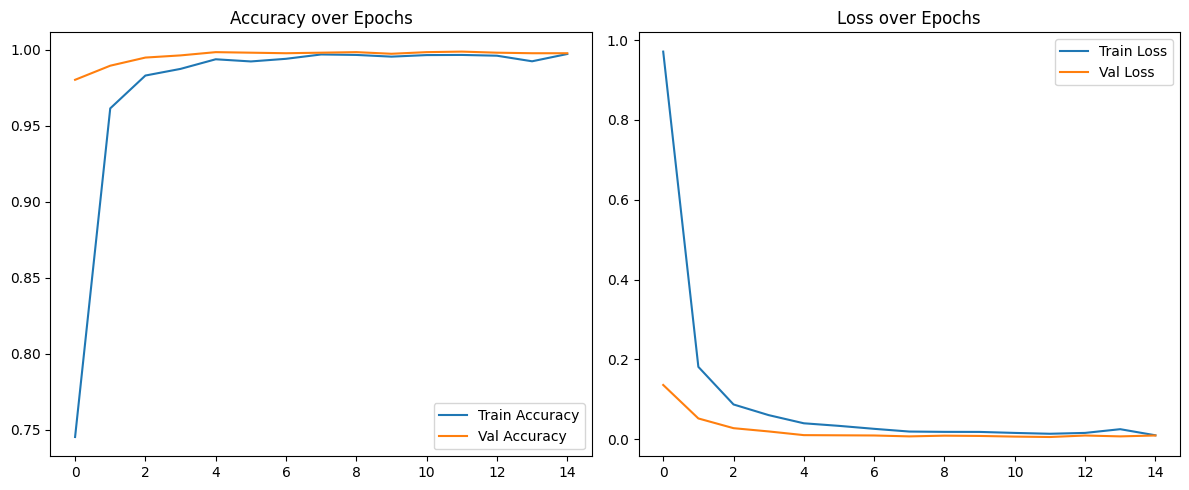

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

<Figure size 2000x2000 with 0 Axes>

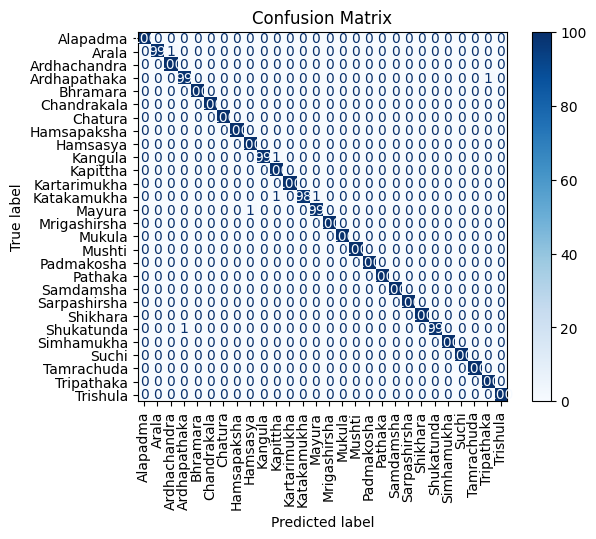

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(20, 20))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


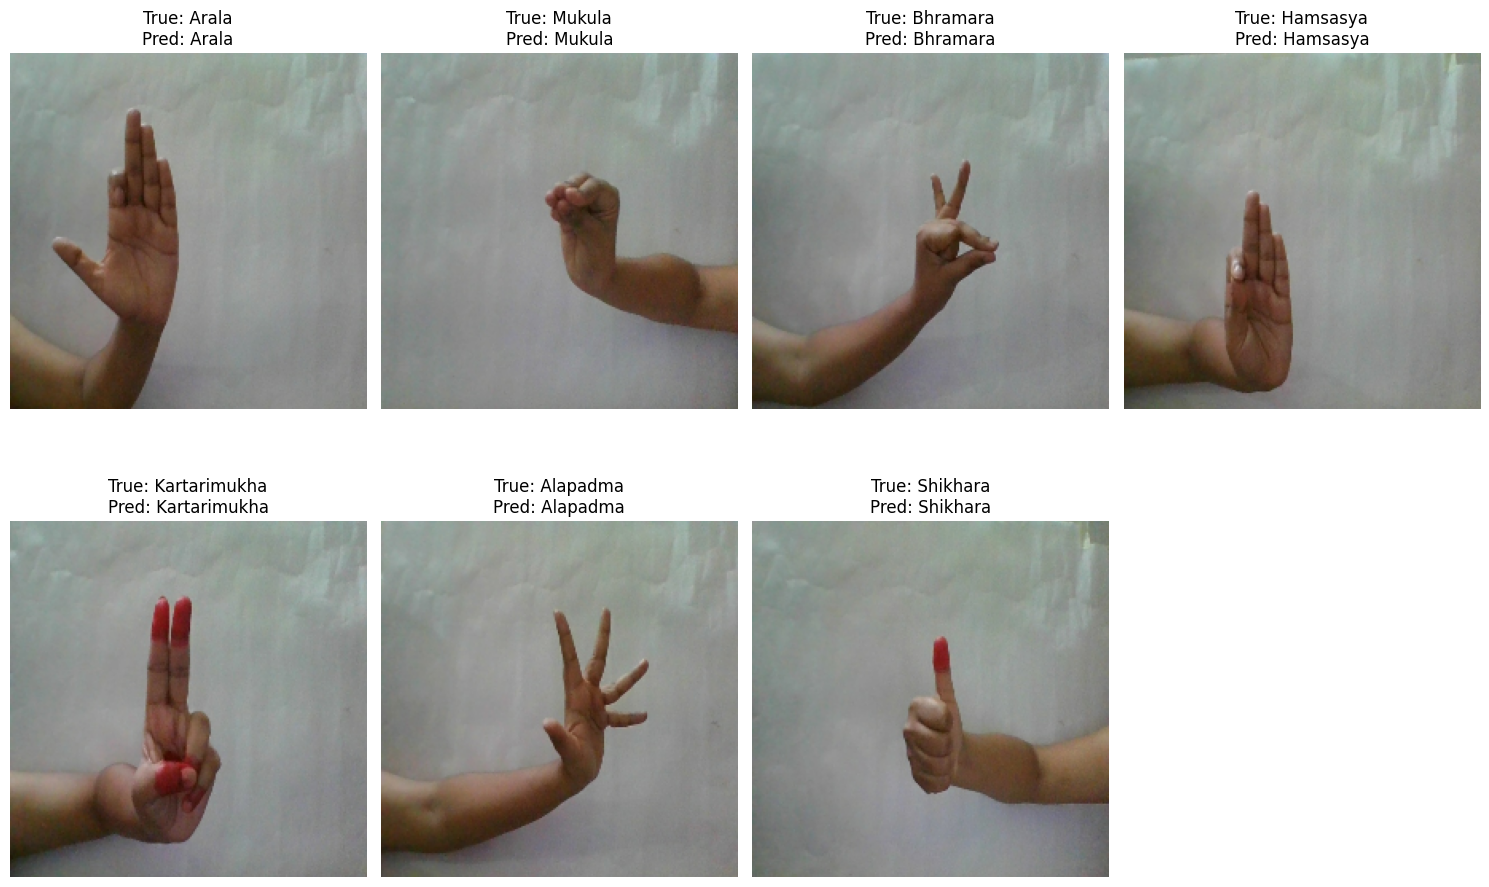

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get 7 images, true labels, and predictions
images_to_plot = []
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for img, true_label, pred_label in zip(images, labels, pred_classes):
        images_to_plot.append(img)
        true_labels.append(true_label.numpy())
        pred_labels.append(pred_label)
        
        if len(images_to_plot) == 7:
            break
    if len(images_to_plot) == 7:
        break

# Plot the 7 images with true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images_to_plot[i].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

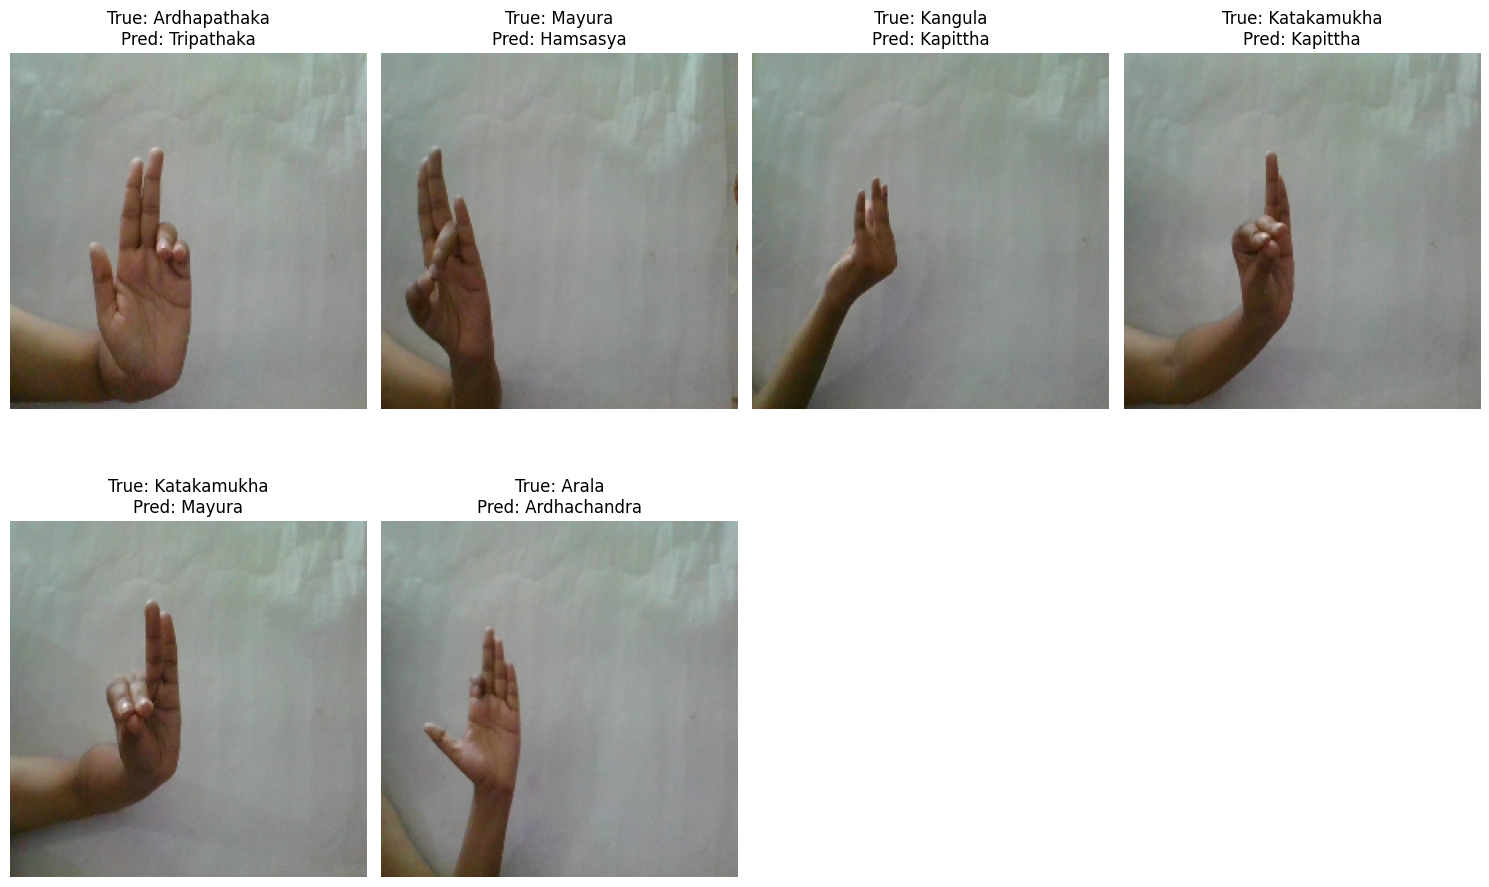

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Collect misclassified images
misclassified_images = []
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    for img, true_label, pred_label in zip(images, labels, pred_classes):
        if true_label.numpy() != pred_label:
            misclassified_images.append(img)
            true_labels.append(true_label.numpy())
            pred_labels.append(pred_label)
        
        if len(misclassified_images) == 6:
            break
    if len(misclassified_images) == 6:
        break

# Plot the misclassified images
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 4, i + 1)
    plt.imshow(misclassified_images[i].numpy().astype("uint8"))
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
model.save("mudra_cnn_model_MobileNetV2.h5")

In [17]:
# model = tf.keras.models.load_model("mudra_cnn_model.h5")